In [1]:
import hist
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "notebook"])

In [2]:
plt.rcParams["font.size"] = 14
plt.rcParams["axes.formatter.limits"] = -5, 4
plt.rcParams["figure.figsize"] = 6, 4
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
from iminuit import cost
from iminuit import Minuit

In [6]:
from scipy.stats import t

In [211]:
import matplotlib as mpl
import matplotlib.gridspec as grid_spec

In [7]:
df = pd.read_csv("features.csv")

In [8]:
df

Unnamed: 0     start_z    nu_energy  target_n_hits  target_n_stations  \
0              0 -197.963898   376.903642            524                 51   
1              1 -155.366440   558.534476            235                 51   
2              2  -98.163406  2441.073357            564                 19   
3              3 -134.552399   394.178693            172                 25   
4              4 -133.161972  1191.206132           1179                 40   
...          ...         ...          ...            ...                ...   
9995        9995 -162.665619   461.519278            893                 58   
9996        9996  -89.597458  1154.187388            143                 11   
9997        9997 -173.237915  3960.131094           1586                 67   
9998        9998  -83.917282  1906.002851             13                  5   
9999        9999 -115.172279  1417.746955            721                 29   

      mufilter_n_hits  mufilter_n_stations  target_n_hits_station_0  \
0                   1                    1                        0   
1                 245                   13                        0   
2                 536                   13                        0   
3                  62                   17                        0   
4                 170                   14                        0   
...               ...                  ...                      ...   
9995               53                    6                        0   
9996              304                    6                        0   
9997              341                   16                        0   
9998              655                   14                        0   
9999                2                    2                        0   

      target_n_hits_station_1  target_n_hits_station_2  ...  \
0                           0                        0  ...   
1                           0                        0  ...   
2                           0                        0  ...   
3                           0                        0  ...   
4                           0                        0  ...   
...                       ...                      ...  ...   
9995                        0                        0  ...   
9996                        0                        0  ...   
9997                        0                        0  ...   
9998                        0                        0  ...   
9999                        0                        0  ...   

      mufilter_n_hits_station_10  mufilter_n_hits_station_11  \
0                              0                           0   
1                              2                           1   
2                              8                           4   
3                              2                           1   
4                              1                           1   
...                          ...                         ...   
9995                           0                           0   
9996                           0                           0   
9997                           3                           1   
9998                           7                           8   
9999                           0                           0   

      mufilter_n_hits_station_12  mufilter_n_hits_station_13  \
0                              0                           0   
1                              1                           0   
2                              2                           0   
3                              1                           0   
4                              1                           1   
...                          ...                         ...   
9995                           0                           0   
9996                           0                           0   
9997                           1                           1   
9998                           6      

In [9]:
start_z = df.pop("start_z").values
nu_energy = np.log(df.pop("nu_energy").values)

In [10]:
X = df.values

In [11]:
from sklearn.datasets import make_regression

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split

In [12]:
from sklearn.ensemble import AdaBoostRegressor

In [13]:
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

In [14]:
import scipy

In [15]:
z_min = -232.3746
z_max = -82.3862

In [16]:
X_train, X_test, start_z_train, start_z_test = train_test_split(
    X, start_z, random_state=0
)

In [17]:
estimate_start_z = GradientBoostingRegressor(random_state=0)

estimate_start_z.fit(X_train, start_z_train)

GradientBoostingRegressor(random_state=0)

In [18]:
# TODO use adaboost and hyperoptimise?

In [19]:
start_z_pred = estimate_start_z.predict(X_test)

estimate_start_z.score(X_test, start_z_test)

0.9930162210871326

In [20]:
h = hist.Hist.new.Regular(10, -10, +10, name=r"𝛥z [cm]").Double()

In [21]:
h.fill(start_z_pred - start_z_test)

Hist(Regular(10, -10, 10, name='𝛥z [cm]'), storage=Double()) # Sum: 2473.0 (2500.0 with flow)

In [22]:
def model(x, mu, sigma):
    return scipy.stats.norm.cdf(x, mu, sigma)

In [23]:
entries, edges = h.to_numpy()

In [24]:
m = Minuit(cost.BinnedNLL(entries, edges, model), 0, 25)

In [25]:
res = m.migrad()

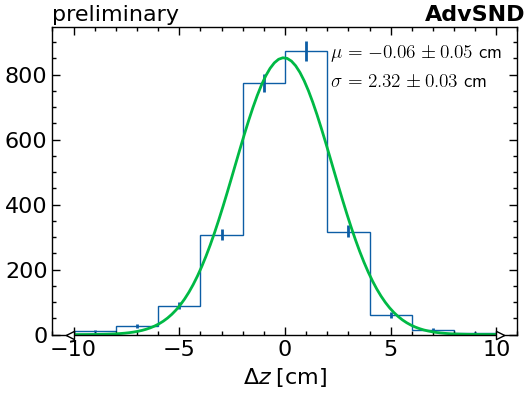

In [26]:
h.plot()
plt.xlabel(r"$\Delta z\;[\mathrm{cm}]$")
plot_range = -10, 10
x = np.linspace(*plot_range, 100)
best_fit = scipy.stats.norm(res.params[0].value, res.params[1].value)
# best_fit = scipy.stats.norm(0.044, 2.83) # TODO take from fit
n_bins = 10
binsize = (plot_range[1] - plot_range[0]) / n_bins
scale = h.sum() / (best_fit.cdf(plot_range[1]) - best_fit.cdf(plot_range[0])) * binsize
plt.plot(x, scale * best_fit.pdf(x))
ax = plt.gca()
# plt.text(0.6, 0.9, r"$\mu = 0.044 $\;cm", transform=ax.transAxes, usetex=True)
plt.text(
    0.6,
    0.9,
    rf"$\mu = {res.params[0].value:.2f} \pm {res.params[0].error:.2f}$\;cm",
    transform=ax.transAxes,
    usetex=True,
)
# plt.text(0.6, 0.81, r"$\sigma = 2.83 $\;cm", transform=ax.transAxes, usetex=True)
plt.text(
    0.6,
    0.81,
    rf"$\sigma = {res.params[1].value:.2f} \pm {res.params[1].error:.2f}$\;cm",
    transform=ax.transAxes,
    usetex=True,
)
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/h_dz.pdf")
plt.savefig("plots/h_dz.png")

In [27]:
X_train, X_test, nu_energy_train, nu_energy_test = train_test_split(
    X, nu_energy, random_state=0
)

In [28]:
estimate_nu_energy = AdaBoostRegressor(
    random_state=0, learning_rate=0.1, n_estimators=466
)

estimate_nu_energy.fit(X_train, nu_energy_train)

AdaBoostRegressor(learning_rate=0.1, n_estimators=466, random_state=0)

In [29]:
"""
bdt_opt = BayesSearchCV(
    AdaBoostRegressor(),
    {
    'learning_rate': Real(0.005, 0.9, prior="log-uniform"),
    'n_estimators': Integer(1, 1000),
},
    n_iter=100,
    cv=5
)

bdt_opt.fit(X_train, nu_energy_train)
"""

'\nbdt_opt = BayesSearchCV(\n    AdaBoostRegressor(),\n    {\n    \'learning_rate\': Real(0.005, 0.9, prior="log-uniform"),\n    \'n_estimators\': Integer(1, 1000),\n},\n    n_iter=100,\n    cv=5\n)\n\nbdt_opt.fit(X_train, nu_energy_train)\n'

In [30]:
"""
bdt_opt.best_params_
"""

'\nbdt_opt.best_params_\n'

In [31]:
nu_energy_pred = estimate_nu_energy.predict(X_test)

estimate_nu_energy.score(X_test, nu_energy_test)

0.5431891093855568

In [32]:
E = np.exp(nu_energy_test)

In [33]:
max(E)

np.float64(4743.82129723046)

In [34]:
E_scale_correction = np.mean(E) - np.mean(np.exp(nu_energy_pred))

In [35]:
dE_over_E = (np.exp(nu_energy_pred) - E) / E

In [36]:
dE_over_E_corrected = (
    (np.exp(nu_energy_pred) + E_scale_correction) - np.exp(nu_energy_test)
) / E

In [37]:
h_nu_energy = hist.Hist.new.Regular(50, -5, +5, name=r"𝛥E/E").Double()

In [38]:
h_nu_energy_corrected = hist.Hist.new.Regular(50, -5, +5, name=r"𝛥E/E").Double()

In [39]:
h_nu_energy.fill(dE_over_E)
h_nu_energy_corrected.fill(dE_over_E_corrected)

Hist(Regular(50, -5, 5, name='𝛥E/E'), storage=Double()) # Sum: 2477.0 (2500.0 with flow)

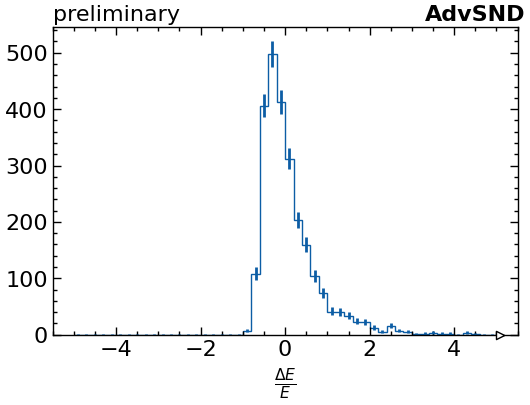

In [40]:
h_nu_energy.plot(label="AdaBoost")
# h_nu_energy_corrected.plot(label="AdaBoost + correction of average")
plt.xlabel(r"$\frac{\Delta E}{E}$")
# plt.legend()
ax = plt.gca()
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/h_dE_over_E.png")
plt.savefig("plots/h_dE_over_E.pdf")

In [41]:
h_dE_over_E_vs_E = (
    hist.Hist.new.Regular(50, 0, 5000, name=r"E")
    .Regular(50, -1, +1, name=r"𝛥E/E")
    .Double()
)

In [42]:
h_dE_over_E_vs_E.fill(E, dE_over_E)

Hist(
  Regular(50, 0, 5000, name='E'),
  Regular(50, -1, 1, name='𝛥E/E'),
  storage=Double()) # Sum: 2281.0 (2500.0 with flow)

In [43]:
h_dE_over_E_vs_E_corrected = (
    hist.Hist.new.Regular(50, 0, 5000, name=r"E")
    .Regular(50, -1, +1, name=r"𝛥E/E")
    .Double()
)

In [44]:
h_dE_over_E_vs_E_corrected.fill(E, dE_over_E_corrected)

Hist(
  Regular(50, 0, 5000, name='E'),
  Regular(50, -1, 1, name='𝛥E/E'),
  storage=Double()) # Sum: 2040.0 (2500.0 with flow)

In [45]:
sorted_E = E.copy()
sorted_E.sort()

/home/olantwin/Projects/snd@lhc/advsnd/calopid/.venv/lib/python3.12/site-packages/mplhep/plot.py:1335: UserWarning: Glyph 120549 (\N{MATHEMATICAL ITALIC CAPITAL DELTA}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw()


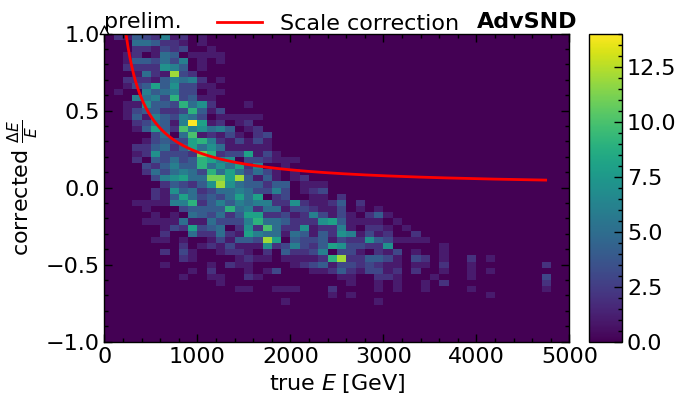

In [46]:
# h_dE_over_E_vs_E.plot()
h_dE_over_E_vs_E_corrected.plot()
plt.plot(sorted_E, E_scale_correction / sorted_E, label="Scale correction", color="red")
ax = plt.gca()
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.xlabel(r"true $E\;[\mathrm{GeV}]$")
plt.ylabel(r"corrected $\frac{\Delta E}{E}$")
plt.legend(loc="upper left", bbox_to_anchor=(0.2, 1.13))
plt.text(
    0.0,
    1.02,
    "prelim.",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/h_dE_over_E_vs_E_corrected.png")
plt.savefig("plots/h_dE_over_E_vs_E_corrected.pdf")

/home/olantwin/Projects/snd@lhc/advsnd/calopid/.venv/lib/python3.12/site-packages/mplhep/plot.py:1335: UserWarning: Glyph 120549 (\N{MATHEMATICAL ITALIC CAPITAL DELTA}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw()


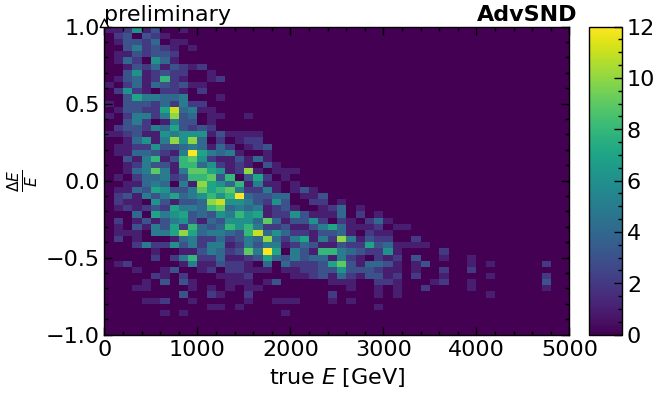

In [47]:
h_dE_over_E_vs_E.plot()
ax = plt.gca()
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.xlabel(r"true $E\;[\mathrm{GeV}]$")
plt.ylabel(r"$\frac{\Delta E}{E}$")
# plt.legend(loc='upper left', bbox_to_anchor=(0.2, 1.13))
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/h_dE_over_E_vs_E.png")
plt.savefig("plots/h_dE_over_E_vs_E.pdf")

In [48]:
h_dE_over_E_vs_E_reco = (
    hist.Hist.new.Regular(
        15, 80, 2500, name=r"E_reco", transform=hist.axis.transform.log
    )
    .Regular(50, -1, +5, name=r"𝛥E/E")
    .Double()
)

In [49]:
h_dE_over_E_vs_E_reco.fill(np.exp(nu_energy_pred), dE_over_E)

Hist(
  Regular(15, 80, 2500, transform=log, name='E_reco'),
  Regular(50, -1, 5, name='𝛥E/E'),
  storage=Double()) # Sum: 2498.0 (2500.0 with flow)

/home/olantwin/Projects/snd@lhc/advsnd/calopid/.venv/lib/python3.12/site-packages/mplhep/plot.py:1335: UserWarning: Glyph 120549 (\N{MATHEMATICAL ITALIC CAPITAL DELTA}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw()


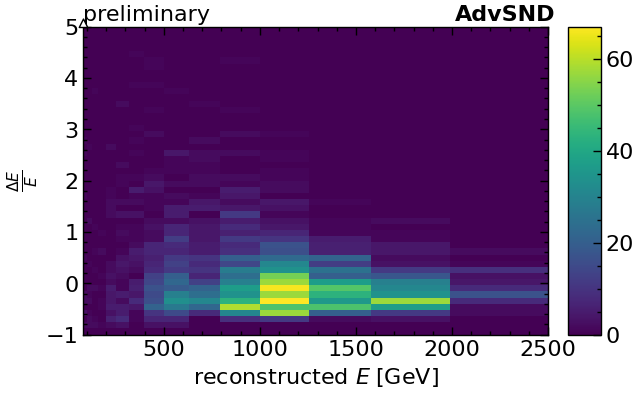

In [50]:
h_dE_over_E_vs_E_reco.plot()
plt.xlabel(r"reconstructed $E\;[\mathrm{GeV}]$")
plt.ylabel(r"$\frac{\Delta E}{E}$")
ax = plt.gca()
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/h_dE_over_E_vs_E_reco.png")
plt.savefig("plots/h_dE_over_E_vs_E_reco.pdf")

In [51]:
np.mean(
    h_dE_over_E_vs_E_reco.values(), axis=1, where=h_dE_over_E_vs_E_reco.values() != 0
)

array([ 1.625     ,  1.55555556,  1.28571429,  1.14285714,  2.82352941,
        2.63636364,  2.6       ,  5.96666667,  9.85714286,  7.48148148,
       14.64285714, 21.40740741, 18.55555556, 15.5       ,  5.6       ])

In [52]:
nu_energy_pred[0]  # TODO how to get bin?

np.float64(6.269723607407916)

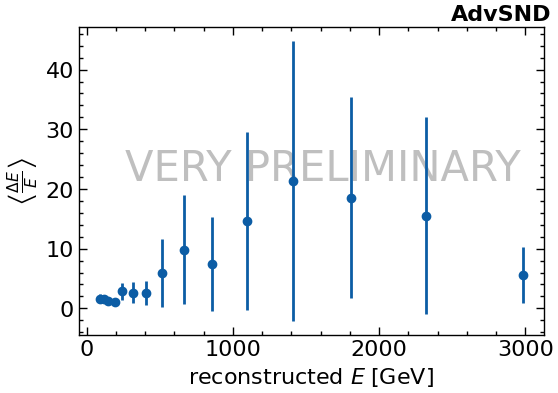

In [53]:
plt.errorbar(
    x=np.logspace(4.5, 8, 15, base=np.e),
    y=np.mean(
        h_dE_over_E_vs_E_reco.values(),
        axis=1,
        where=h_dE_over_E_vs_E_reco.values() != 0,
    ),
    yerr=np.std(
        h_dE_over_E_vs_E_reco.values(),
        axis=1,
        where=h_dE_over_E_vs_E_reco.values() != 0,
    ),
    linestyle="none",
    marker="o",
)

ax = plt.gca()
plt.text(
    0.1,
    0.5,
    "VERY PRELIMINARY",
    fontfamily="sans-serif",
    fontsize=30,
    transform=ax.transAxes,
    usetex=False,
    color="gray",
    zorder=0,
    alpha=0.5,
)
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
# plt.plot(np.logspace(4.5, 8, 15, base=np.e), res.intercept + res.slope*np.linspace(np.exp(4.5), np.exp(8), 15), 'r', label='fitted line')
plt.xlabel(r"reconstructed $E\;[\mathrm{GeV}]$")
plt.ylabel(r"$\left<\frac{\Delta E}{E}\right>$")
plt.savefig("plots/non_const_correction.png")
plt.savefig("plots/non_const_correction.pdf")
# TODO y-axis makes no sense!

In [54]:
res = scipy.stats.linregress(
    np.linspace(np.exp(4.5), np.exp(8), 15),
    np.mean(
        h_dE_over_E_vs_E_reco.values(),
        axis=1,
        where=h_dE_over_E_vs_E_reco.values() != 0,
    ),
)

In [55]:
res

LinregressResult(slope=np.float64(0.0057300452058156506), intercept=np.float64(-1.2864043841269854), rvalue=np.float64(0.7703372315675947), pvalue=np.float64(0.0007784473668794167), stderr=np.float64(0.0013154634414310749), intercept_stderr=np.float64(2.3360786859857083))

In [56]:
# Two-sided inverse Students t-distribution

# p - probability, df - degrees of freedom


tinv = lambda p, df: abs(t.ppf(p / 2, df))

In [57]:
ts = tinv(0.05, 15 - 2)

print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")

print(f"intercept (95%): {res.intercept:.6f}" f" +/- {ts*res.intercept_stderr:.6f}")

slope (95%): 0.005730 +/- 0.002842
intercept (95%): -1.286404 +/- 5.046791


In [58]:
# TODO average percentage difference per bin? Use to correct?

In [59]:
h_E_true_vs_E_reco = (
    hist.Hist.new.Regular(100, 0, 5000, name=r"E_true")
    .Regular(100, 0, 5000, name=r"E_reco")
    .Double()
)

In [60]:
h_E_true_vs_E_reco.fill(E, np.exp(nu_energy_pred))

Hist(
  Regular(100, 0, 5000, name='E_true'),
  Regular(100, 0, 5000, name='E_reco'),
  storage=Double()) # Sum: 2500.0

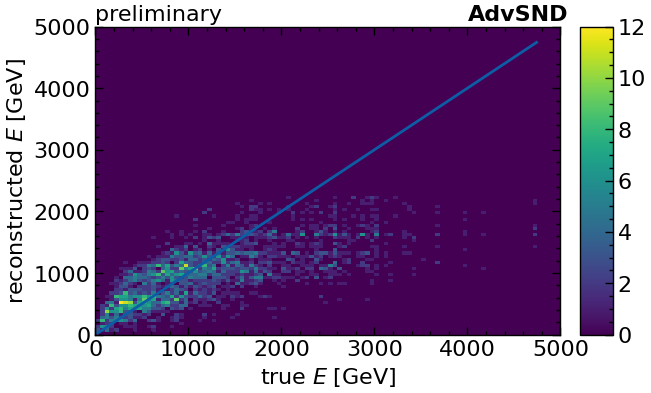

In [61]:
h_E_true_vs_E_reco.plot()
plt.plot(sorted_E, sorted_E)
plt.xlabel(r"true $E\;[\mathrm{GeV}]$")
plt.ylabel(r"reconstructed $E\;[\mathrm{GeV}]$")
ax = plt.gca()
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/h_E_true_vs_E_reco.png")
plt.savefig("plots/h_E_true_vs_E_reco.pdf")

# Is the position independent of energy?

In [62]:
h_dE_over_E_vs_z = (
    hist.Hist.new.Regular(50, -200, -80, name=r"z")
    .Regular(50, -1, +4, name=r"𝛥E/E")
    .Double()
)

In [63]:
h_dE_over_E_vs_z.fill(start_z_test, dE_over_E)

Hist(
  Regular(50, -200, -80, name='z'),
  Regular(50, -1, 4, name='𝛥E/E'),
  storage=Double()) # Sum: 2494.0 (2500.0 with flow)

In [64]:
h_dE_over_E_vs_dz = (
    hist.Hist.new.Regular(50, -10, 10, name=r"z")
    .Regular(50, -1, +4, name=r"𝛥E/E")
    .Double()
)

In [65]:
h_dE_over_E_vs_dz.fill(start_z_test - start_z_pred, dE_over_E)

Hist(
  Regular(50, -10, 10, name='z'),
  Regular(50, -1, 4, name='𝛥E/E'),
  storage=Double()) # Sum: 2467.0 (2500.0 with flow)

/home/olantwin/Projects/snd@lhc/advsnd/calopid/.venv/lib/python3.12/site-packages/mplhep/plot.py:1335: UserWarning: Glyph 120549 (\N{MATHEMATICAL ITALIC CAPITAL DELTA}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw()


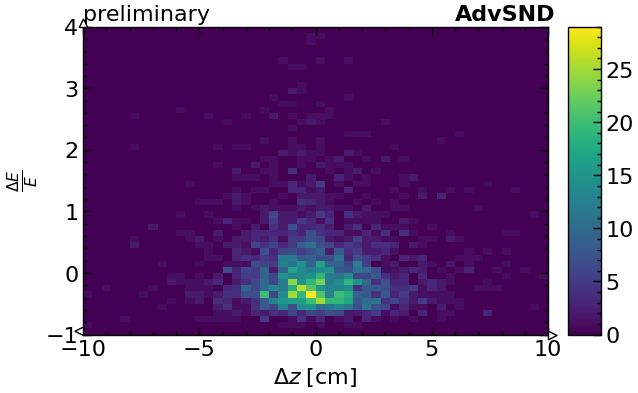

In [66]:
h_dE_over_E_vs_dz.plot()
plt.ylabel(r"$\frac{\Delta E}{E}$")
plt.xlabel(r"$\Delta z\;[\mathrm{cm}]$")
ax = plt.gca()
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/h_dE_over_E_vs_dz.pdf")
plt.savefig("plots/h_dE_over_E_vs_dz.png")

/home/olantwin/Projects/snd@lhc/advsnd/calopid/.venv/lib/python3.12/site-packages/mplhep/plot.py:1335: UserWarning: Glyph 120549 (\N{MATHEMATICAL ITALIC CAPITAL DELTA}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw()


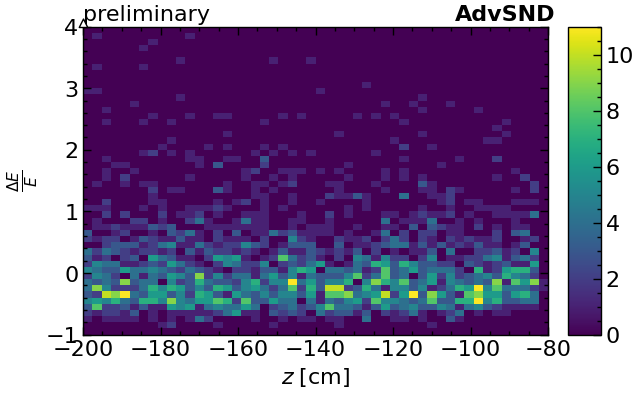

In [67]:
h_dE_over_E_vs_z.plot()
plt.ylabel(r"$\frac{\Delta E}{E}$")
plt.xlabel(r"$z\;[\mathrm{cm}]$")
ax = plt.gca()
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/h_dE_over_E_vs_z.pdf")
plt.savefig("plots/h_dE_over_E_vs_z.png")

Position resolution seems independent of energy, can smear true position using position resolution.

In [68]:
np.mean(start_z_test - start_z_pred)

np.float64(0.04441014429456604)

In [69]:
np.std(start_z_test - start_z_pred)

np.float64(2.8287693371996445)

## Smear start by gaussian and retrain energy regressions

In [70]:
scipy.stats.norm(
    loc=np.mean(start_z_test - start_z_pred), scale=np.std(start_z_test - start_z_pred)
).rvs(10000)  # TODO update with values from fit

array([-2.25322015, -3.68997732,  1.24581012, ..., -4.33249206,
       -1.52853759,  2.04399843])

In [71]:
df["z_smeared"] = start_z + scipy.stats.norm(
    loc=np.mean(start_z_test - start_z_pred), scale=np.std(start_z_test - start_z_pred)
).rvs(10000)

In [72]:
df

Unnamed: 0  target_n_hits  target_n_stations  mufilter_n_hits  \
0              0            524                 51                1   
1              1            235                 51              245   
2              2            564                 19              536   
3              3            172                 25               62   
4              4           1179                 40              170   
...          ...            ...                ...              ...   
9995        9995            893                 58               53   
9996        9996            143                 11              304   
9997        9997           1586                 67              341   
9998        9998             13                  5              655   
9999        9999            721                 29                2   

      mufilter_n_stations  target_n_hits_station_0  target_n_hits_station_1  \
0                       1                        0                        0   
1                      13                        0                        0   
2                      13                        0                        0   
3                      17                        0                        0   
4                      14                        0                        0   
...                   ...                      ...                      ...   
9995                    6                        0                        0   
9996                    6                        0                        0   
9997                   16                        0                        0   
9998                   14                        0                        0   
9999                    2                        0                        0   

      target_n_hits_station_2  target_n_hits_station_3  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   
...                       ...                      ...   
9995                        0                        0   
9996                        0                        0   
9997                        0                        0   
9998                        0                        0   
9999                        0                        0   

      target_n_hits_station_4  ...  mufilter_n_hits_station_11  \
0                           0  ...                           0   
1                           0  ...                           1   
2                           0  ...                           4   
3                           0  ...                           1   
4                           0  ...                           1   
...                       ...  ...                         ...   
9995                        0  ...                           0   
9996                        0  ...                           0   
9997                        0  ...                           1   
9998                        0  ...                           8   
9999                        0  ...                           0   

      mufilter_n_hits_station_12  mufilter_n_hits_station_13  \
0                              0                           0   
1                              1                           0   
2                              2                           0   
3                              1                           0   
4                              1                           1   
...                          ...                         ...   
9995                           0                           0   
9996                           0                           0   
9997                           1                           1   
9998                           6                           4   
9999      

In [73]:
X = df.values

In [74]:
X_train, X_test, nu_energy_train, nu_energy_test = train_test_split(
    X, nu_energy, random_state=0
)

In [75]:
"""
bdt_opt_smeared = BayesSearchCV(
    AdaBoostRegressor(),
    {
    'learning_rate': Real(0.005, 0.9, prior="log-uniform"),
    'n_estimators': Integer(1, 1000),
},
    n_iter=20,
    cv=3
)

bdt_opt_smeared.fit(X_train[:1000], nu_energy_train[:1000])
"""

'\nbdt_opt_smeared = BayesSearchCV(\n    AdaBoostRegressor(),\n    {\n    \'learning_rate\': Real(0.005, 0.9, prior="log-uniform"),\n    \'n_estimators\': Integer(1, 1000),\n},\n    n_iter=20,\n    cv=3\n)\n\nbdt_opt_smeared.fit(X_train[:1000], nu_energy_train[:1000])\n'

In [76]:
"""
bdt_opt_smeared.best_params_
"""

'\nbdt_opt_smeared.best_params_\n'

In [77]:
estimate_nu_energy_with_smeared_z = AdaBoostRegressor(
    random_state=0, learning_rate=0.08, n_estimators=610
)

estimate_nu_energy_with_smeared_z.fit(X_train, nu_energy_train)

AdaBoostRegressor(learning_rate=0.08, n_estimators=610, random_state=0)

In [78]:
nu_energy_pred = estimate_nu_energy_with_smeared_z.predict(X_test)

estimate_nu_energy_with_smeared_z.score(X_test, nu_energy_test)

0.5400307575817849

(array([ 61., 614., 875., 447., 249., 150.,  64.,  23.,   9.,   8.]),
 array([-989.54331473, -570.61681845, -151.69032217,  267.23617412,
         686.1626704 , 1105.08916668, 1524.01566296, 1942.94215924,
        2361.86865553, 2780.79515181, 3199.72164809]),
 <BarContainer object of 10 artists>)

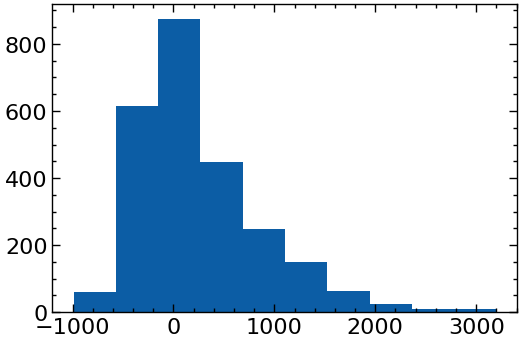

In [79]:
plt.hist(np.exp(nu_energy_test) - np.exp(nu_energy_pred))

* Shouldn't have expected improvement just because of smeared (or even *true* z).
* Important to translate strips per station by the start station (how to deal with HCAL?)

(array([1071., 1001.,  965.,  967., 1023.,  987., 1029., 1009.,  981.,
         967.]),
 array([  0.        ,  11.77081833,  23.54163666,  35.31245499,
         47.08327332,  58.85409164,  70.62490997,  82.3957283 ,
         94.16654663, 105.93736496, 117.70818329]),
 <BarContainer object of 10 artists>)

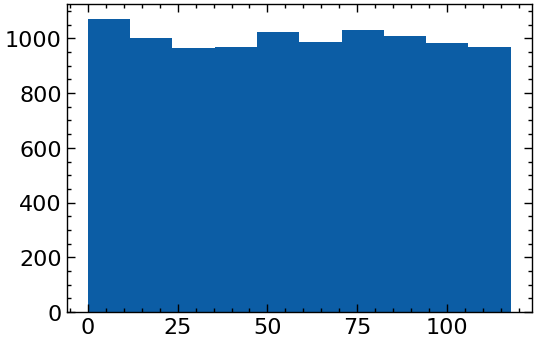

In [80]:
plt.hist(start_z - min(start_z))

In [81]:
df["smeared_start_station"] = np.clip(
    ((df.z_smeared - (-232.3746)) / 1.5).astype(int), 0, 99
)

In [82]:
df

Unnamed: 0  target_n_hits  target_n_stations  mufilter_n_hits  \
0              0            524                 51                1   
1              1            235                 51              245   
2              2            564                 19              536   
3              3            172                 25               62   
4              4           1179                 40              170   
...          ...            ...                ...              ...   
9995        9995            893                 58               53   
9996        9996            143                 11              304   
9997        9997           1586                 67              341   
9998        9998             13                  5              655   
9999        9999            721                 29                2   

      mufilter_n_stations  target_n_hits_station_0  target_n_hits_station_1  \
0                       1                        0                        0   
1                      13                        0                        0   
2                      13                        0                        0   
3                      17                        0                        0   
4                      14                        0                        0   
...                   ...                      ...                      ...   
9995                    6                        0                        0   
9996                    6                        0                        0   
9997                   16                        0                        0   
9998                   14                        0                        0   
9999                    2                        0                        0   

      target_n_hits_station_2  target_n_hits_station_3  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   
...                       ...                      ...   
9995                        0                        0   
9996                        0                        0   
9997                        0                        0   
9998                        0                        0   
9999                        0                        0   

      target_n_hits_station_4  ...  mufilter_n_hits_station_12  \
0                           0  ...                           0   
1                           0  ...                           1   
2                           0  ...                           2   
3                           0  ...                           1   
4                           0  ...                           1   
...                       ...  ...                         ...   
9995                        0  ...                           0   
9996                        0  ...                           0   
9997                        0  ...                           1   
9998                        0  ...                           6   
9999                        0  ...                           0   

      mufilter_n_hits_station_13  mufilter_n_hits_station_14  \
0                              0                           0   
1                              0                           0   
2                              0                           0   
3                              0                           1   
4                              1                           1   
...                          ...                         ...   
9995                           0                           0   
9996                           0                           0   
9997                           1                           3   
9998                           4                           0   
9999      

In [83]:
df.smeared_start_station.max()

np.int64(99)

In [84]:
absolute_strip_counts = df[[f"target_n_hits_station_{n}" for n in range(100)]].values

In [85]:
X[:, 0:-2]

array([[0.000e+00, 5.240e+02, 5.100e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 2.350e+02, 5.100e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+00, 5.640e+02, 1.900e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [9.997e+03, 1.586e+03, 6.700e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [9.998e+03, 1.300e+01, 5.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [9.999e+03, 7.210e+02, 2.900e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [86]:
np.roll(absolute_strip_counts[0], -24)

array([19, 24, 30, 33, 33, 28, 33, 24, 23, 27, 21, 13, 14, 11, 12, 12, 12,
        8,  5,  6,  5,  5,  6,  5,  7,  9, 10, 11,  5,  2,  3,  2,  4,  3,
        7,  6,  5,  2,  2,  1,  0,  1,  0,  2,  0,  0,  1,  0,  2,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  2,  1,  4, 10, 11])

In [87]:
A = absolute_strip_counts

In [88]:
r = -df.smeared_start_station.values

In [89]:
# https://stackoverflow.com/a/20361561

rows, column_indices = np.ogrid[: A.shape[0], : A.shape[1]]

# Always use a negative shift, so that column_indices are valid.
# Alternative: r %= A.shape[1]
r[r < 0] += A.shape[1]
column_indices = column_indices - r[:, np.newaxis]

result = A[rows, column_indices]

In [90]:
r

array([79, 46, 13, ..., 61,  3, 24])

In [91]:
result

array([[ 4, 10, 11, ...,  0,  2,  1],
       [ 6,  4, 10, ...,  1,  2,  7],
       [ 5,  3, 12, ...,  0,  4,  2],
       ...,
       [13, 19, 26, ...,  3,  4, 11],
       [ 1,  3,  7, ...,  0,  1,  1],
       [ 0,  4, 11, ...,  1,  1,  1]])

In [92]:
X_relative = result

In [93]:
X_relative = np.concatenate([X[:, 1:-2], result], axis=1)

In [94]:
X_rel_train, X_rel_test, log_E_rel_train, log_E_rel_test = train_test_split(
    X_relative, nu_energy, random_state=0
)

In [96]:
estimate_nu_energy_rel = AdaBoostRegressor(
    random_state=0, learning_rate=0.1, n_estimators=500
)
estimate_nu_energy_rel.fit(X_rel_train, log_E_rel_train)

AdaBoostRegressor(learning_rate=0.1, n_estimators=500, random_state=0)

In [97]:
log_E_rel_pred = estimate_nu_energy_rel.predict(X_rel_test)
estimate_nu_energy_rel.score(X_rel_test, log_E_rel_test)

0.6273368013963891

In [98]:
# TODO missing global info and HCAL info!
# TODO how to make the HCAL info relative to position?

In [99]:
E_rel_pred = np.exp(log_E_rel_pred)
E_rel_test = np.exp(log_E_rel_test)

In [110]:
dE_rel = E_rel_pred - E_rel_test

In [111]:
dE_over_E_rel = dE_rel / E_rel_test

In [101]:
h_dE_over_E_rel_vs_E_rel_test = (
    hist.Hist.new.Regular(50, 0, 5000, name=r"E")
    .Regular(50, -1, +1, name=r"𝛥E/E")
    .Double()
)

In [102]:
h_dE_over_E_rel_vs_E_rel_test.fill(E_rel_test, dE_over_E_rel)

Hist(
  Regular(50, 0, 5000, name='E'),
  Regular(50, -1, 1, name='𝛥E/E'),
  storage=Double()) # Sum: 2277.0 (2500.0 with flow)

/home/olantwin/Projects/snd@lhc/advsnd/calopid/.venv/lib/python3.12/site-packages/mplhep/plot.py:1335: UserWarning: Glyph 120549 (\N{MATHEMATICAL ITALIC CAPITAL DELTA}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw()


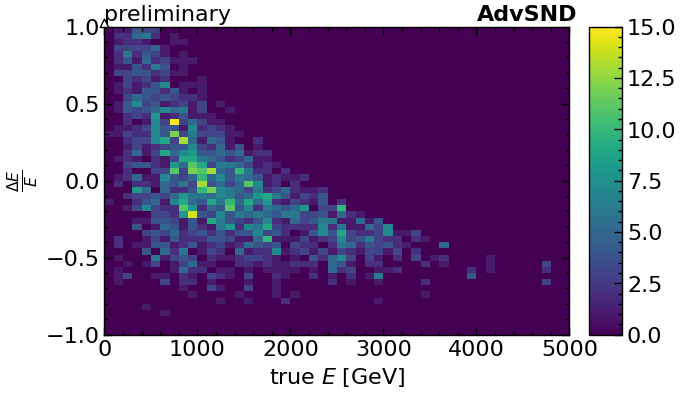

In [103]:
h_dE_over_E_rel_vs_E_rel_test.plot()
ax = plt.gca()
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.xlabel(r"true $E\;[\mathrm{GeV}]$")
plt.ylabel(r"$\frac{\Delta E}{E}$")
# plt.legend(loc='upper left', bbox_to_anchor=(0.2, 1.13))
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/h_dE_over_E_rel_vs_E_rel_test.pdf")
plt.savefig("plots/h_dE_over_E_rel_vs_E_rel_test.png")

In [104]:
h_E_rel_test_vs_E_rel_pred = (
    hist.Hist.new.Regular(100, 0, 5000, name=r"E_true")
    .Regular(100, 0, 5000, name=r"E_reco")
    .Double()
)

In [105]:
h_E_rel_test_vs_E_rel_pred.fill(E_rel_test, E_rel_pred)

Hist(
  Regular(100, 0, 5000, name='E_true'),
  Regular(100, 0, 5000, name='E_reco'),
  storage=Double()) # Sum: 2500.0

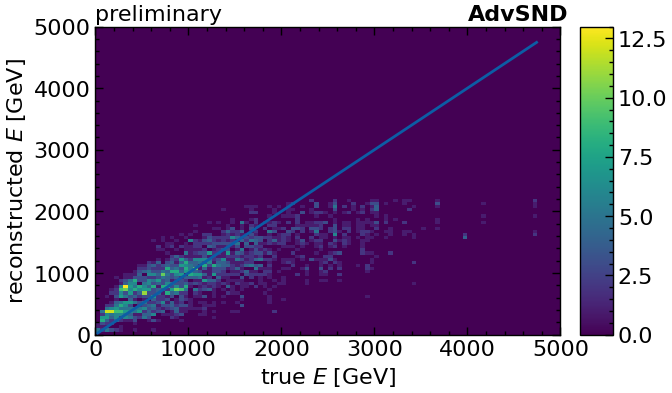

In [106]:
h_E_rel_test_vs_E_rel_pred.plot()
plt.plot(sorted_E, sorted_E)
plt.xlabel(r"true $E\;[\mathrm{GeV}]$")
plt.ylabel(r"reconstructed $E\;[\mathrm{GeV}]$")
ax = plt.gca()
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/h_E_rel_test_vs_E_rel_pred.pdf")
plt.savefig("plots/h_E_rel_test_vs_E_rel_pred.png")

In [107]:
h_dE_over_E_rel = hist.Hist.new.Regular(50, -5, +5, name=r"𝛥E/E").Double()

In [108]:
h_dE_over_E_rel.fill(dE_over_E_rel)

Hist(Regular(50, -5, 5, name='𝛥E/E'), storage=Double()) # Sum: 2500.0

Text(0.8, 1.02, 'AdvSND')

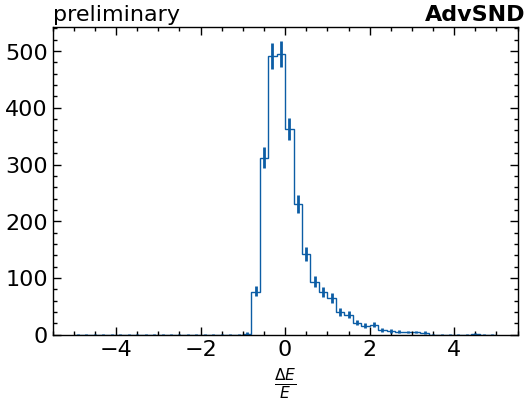

In [109]:
# h_nu_energy.plot(label="BDT")
# h_nu_energy_corrected.plot(label="+correction of average")
h_dE_over_E_rel.plot(label="+relative ECAL info")
plt.xlabel(r"$\frac{\Delta E}{E}$")
# plt.legend()
ax = plt.gca()
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)

In [113]:
max(dE_rel)

np.float64(925.190514201597)

In [131]:
max(E_rel_pred)

np.float64(2179.7895748932638)

In [258]:
bins_E_reco = 15

In [259]:
h_dE_rel_test_vs_E_rel_pred = (
    hist.Hist.new.Regular(100, -3150, 950, name=r"dE")
    .Regular(bins_E_reco, 60, 2200, name=r"E_reco", transform=hist.axis.transform.log)
    .Double()
)

In [260]:
h_dE_rel_test_vs_E_rel_pred.fill(dE_rel, E_rel_pred)

Hist(
  Regular(100, -3150, 950, name='dE'),
  Regular(15, 60, 2200, transform=log, name='E_reco'),
  storage=Double()) # Sum: 2500.0

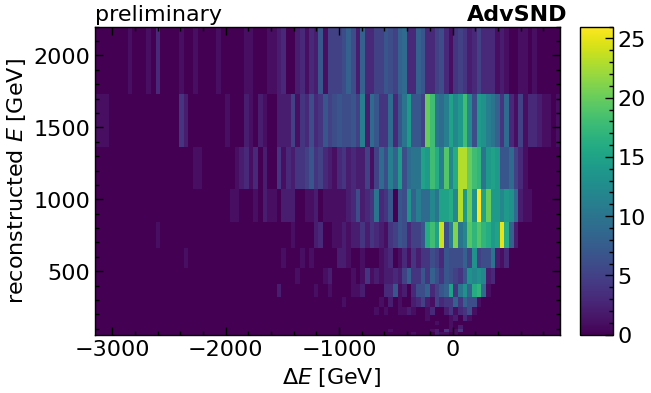

In [261]:
h_dE_rel_test_vs_E_rel_pred.plot()
plt.xlabel(r" $\Delta E\;[\mathrm{GeV}]$")
plt.ylabel(r"reconstructed $E\;[\mathrm{GeV}]$")
ax = plt.gca()
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/h_dE_rel_test_vs_E_rel_pred.pdf")
plt.savefig("plots/h_dE_rel_test_vs_E_rel_pred.png")

In [262]:
def model(x, mu, sigma):
    return scipy.stats.norm.cdf(x, loc=mu, scale=sigma)

/tmp/ipykernel_161992/2010025385.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


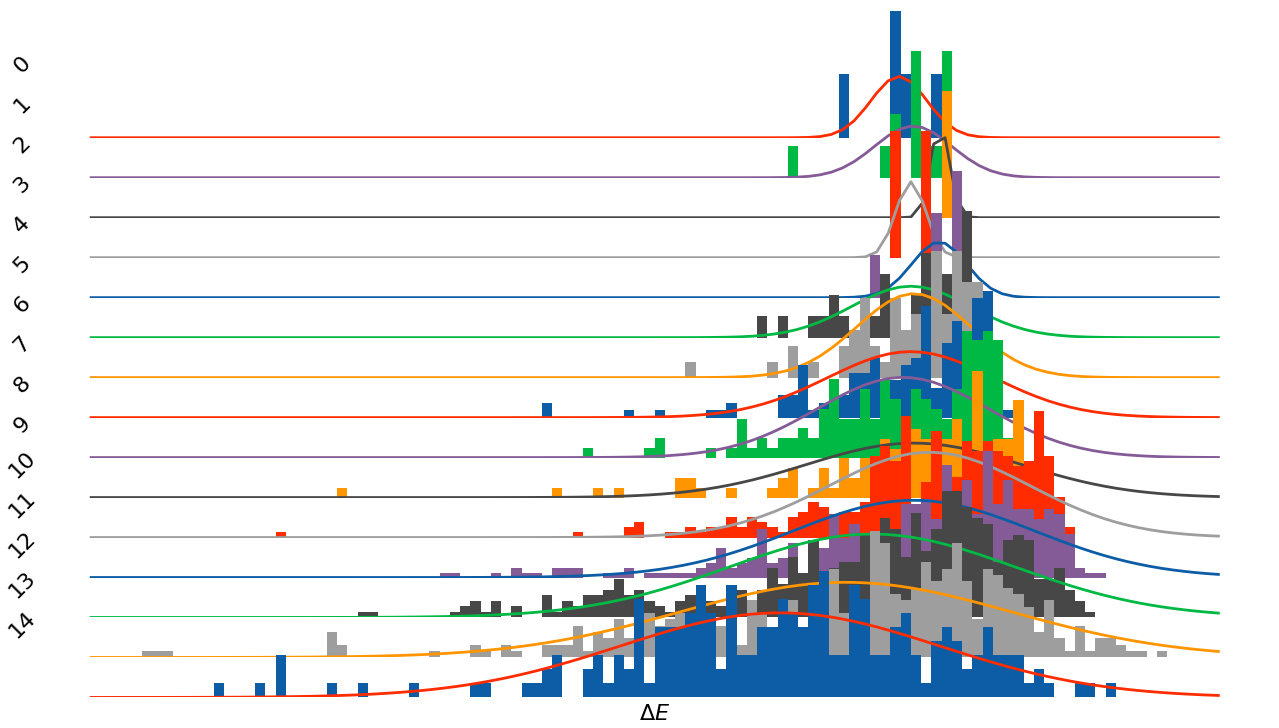

In [263]:
gs = grid_spec.GridSpec(bins_E_reco, 1)
fig = plt.figure(figsize=(16, 9))

i = 0
mus = []
sigmas = []
bins = []

ax_objs = []
for bin in range(bins_E_reco):
    # country = countries[i]
    # = np.array(data[data.country == country].score)
    # x_d = np.linspace(0,1, 1000)

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i : i + 1, 0:]))

    # plotting the distribution
    h = h_dE_rel_test_vs_E_rel_pred[:, bin]
    h.plot(yerr=False, ax=ax_objs[-1], color=colors[bin % len(colors)], histtype="fill")
    entries, edges = h.to_numpy()
    n_bins = len(entries)
    m = Minuit(cost.BinnedNLL(entries, edges, model), 0, 25)
    res = m.migrad()
    if res.valid:
        plot_range = ax_objs[-1].get_xlim()
        x = np.linspace(*plot_range, 100)
        best_fit = scipy.stats.norm(res.params[0].value, res.params[1].value)
        binsize = (plot_range[1] - plot_range[0]) / n_bins
        scale = (
            h.sum()
            / (best_fit.cdf(plot_range[1]) - best_fit.cdf(plot_range[0]))
            * binsize
        )
        ax_objs[-1].plot(
            x, scale * best_fit.pdf(x), color=colors[(bin + 3) % len(colors)]
        )
        bins.append(bin)
        mus.append(res.params[0])
        sigmas.append(res.params[1])
    else:
        print(res)

    # setting uniform x and y lims
    # ax_objs[-1].set_ylim(0,2.5)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == bins_E_reco - 1:
        ax_objs[-1].set_xlabel(r"$\Delta E$", fontsize=16, fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])
        ax_objs[-1].set_xlabel("")

    ax_objs[-1].set_ylabel(str(bin), rotation=45)
    ax_objs[-1].set_yticks([])
    ax_objs[-1].set_xticks([])

    spines = ["top", "right", "left", "bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    #  ax_objs[-1].text(-0.02,0,adj_country,fontweight="bold",fontsize=14,ha="right")

    i += 1

gs.update(hspace=-0.7)
# gs.update()

plt.tight_layout()
plt.show()

In [265]:
bin_edges = h_dE_rel_test_vs_E_rel_pred[0, :].to_numpy()[1]
bin_centres = (bin_edges[1:] + bin_edges[:-1]) / 2
bin_half_widths = (bin_edges[1:] - bin_edges[:-1]) / 2

Text(0.5, 0, '$E_\\mathrm{reco}\\;[\\mathrm{GeV}]$')

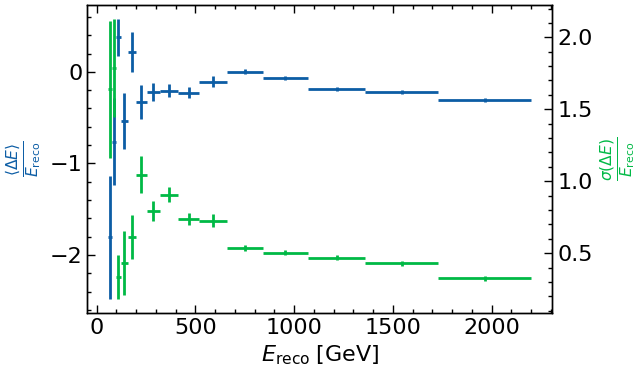

In [304]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.set_xlabel("X data")
ax1.set_ylabel("Y1 data", color="g")
ax2.set_ylabel("Y2 data", color="b")
ax1.errorbar(
    bin_centres[bins],
    [mu.value for mu in mus] / bin_centres[bins],
    xerr=bin_half_widths[bins],
    yerr=[mu.error for mu in mus] / bin_centres[bins],
    linestyle="",
    label=r"$\left<\Delta E\right>$",
    color=colors[0],
)
ax2.errorbar(
    bin_centres[bins],
    [sigma.value for sigma in sigmas] / bin_centres[bins],
    xerr=bin_half_widths[bins],
    yerr=[sigma.error for sigma in sigmas] / bin_centres[bins],
    linestyle="",
    label=r"$\sigma\left(\Delta E\right)$",
    color=colors[1],
)
# ax1.hlines(0, *plt.xlim(), color='red')
ax1.set_ylabel(r"$\frac{\left<\Delta E\right>}{E_\mathrm{reco}}$", color=colors[0])
ax2.set_ylabel(
    r"$\frac{\sigma\left(\Delta E\right)}{E_\mathrm{reco}}$", color=colors[1]
)
ax1.set_xlabel(r"$E_\mathrm{reco}\;[\mathrm{GeV}]$")

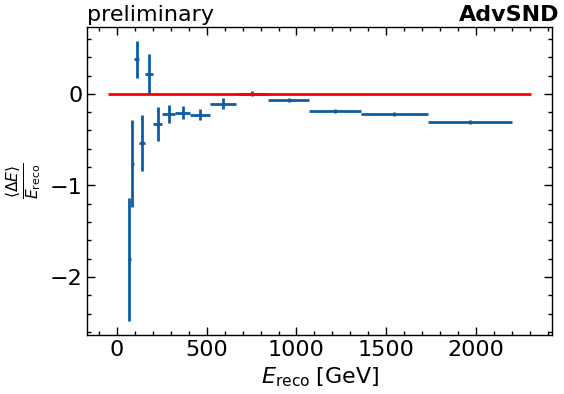

In [314]:
plt.errorbar(
    bin_centres[bins],
    [mu.value for mu in mus] / bin_centres[bins],
    xerr=bin_half_widths[bins],
    yerr=[mu.error for mu in mus] / bin_centres[bins],
    linestyle="",
    label=r"$\left<\Delta E\right>$",
    color=colors[0],
)
plt.hlines(0, *plt.xlim(), color="red")
plt.ylabel(r"$\frac{\left<\Delta E\right>}{E_\mathrm{reco}}$")
plt.xlabel(r"$E_\mathrm{reco}\;[\mathrm{GeV}]$")
ax = plt.gca()
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/energy_bias.pdf")
plt.savefig("plots/energy_bias.png")

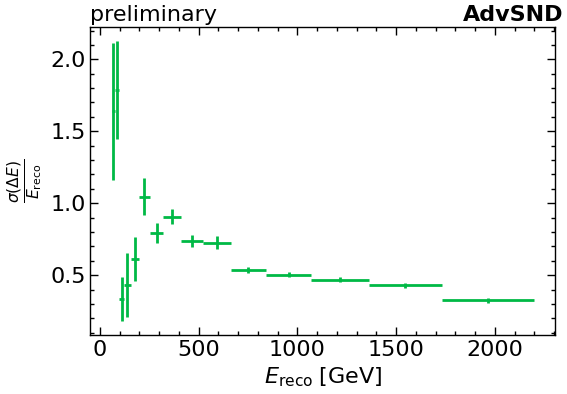

In [313]:
plt.errorbar(
    bin_centres[bins],
    [sigma.value for sigma in sigmas] / bin_centres[bins],
    xerr=bin_half_widths[bins],
    yerr=[sigma.error for sigma in sigmas] / bin_centres[bins],
    linestyle="",
    label=r"$\sigma\left(\Delta E\right)$",
    color=colors[1],
)
plt.ylabel(r"$\frac{\sigma\left(\Delta E\right)}{E_\mathrm{reco}}$")
plt.xlabel(r"$E_\mathrm{reco}\;[\mathrm{GeV}]$")
ax = plt.gca()
plt.text(
    0.0,
    1.02,
    "preliminary",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.text(
    0.8,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)
plt.savefig("plots/energy_resolution.pdf")
plt.savefig("plots/energy_resolution.png")